# FullClass-TrainCNN_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=260
img_width=260
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


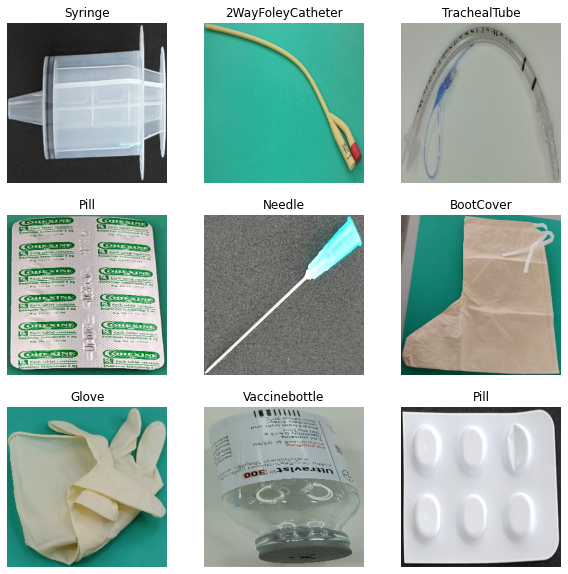

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 260, 260, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB2

efficientnetB0_model = keras.applications.EfficientNetB2(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


37445632/37432240 [==============================] - 14s 0us/step


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1408)              7768569   
_________________________________________________________________
dense (Dense)                (None, 1024)              1442816   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 9,253,410
Trainable params: 1,484,841
Non-trainable params: 7,768,569
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 47s 364ms/step - loss: 1.0827 - accuracy: 0.7257 - val_loss: 0.2626 - val_accuracy: 0.9353
Epoch 2/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.1978 - accuracy: 0.9435 - val_loss: 0.1607 - val_accuracy: 0.9534
Epoch 3/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.0963 - accuracy: 0.9780 - val_loss: 0.1635 - val_accuracy: 0.9470
Epoch 4/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.0643 - accuracy: 0.9874 - val_loss: 0.1401 - val_accuracy: 0.9521
Epoch 5/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.0447 - accuracy: 0.9900 - val_loss: 0.1366 - val_accuracy: 0.9560
Epoch 6/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.0380 - accuracy: 0.9910 - val_loss: 0.1102 - val_accuracy: 0.9690
Epoch 7/2000
49/49 [==============================] - 11s 222ms/step - loss: 0.0229 - accuracy: 0.9977 - val_loss: 0.0898 - val_ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 11s 217ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0665 - val_accuracy: 0.9819
Epoch 202/2000
49/49 [==============================] - 11s 217ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0664 - val_accuracy: 0.9819
Epoch 203/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9819
Epoch 204/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0659 - val_accuracy: 0.9819
Epoch 205/2000
49/49 [==============================] - 11s 217ms/step - loss: 9.5640e-04 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9819
Epoch 206/2000
49/49 [==============================] - 11s 216ms/step - loss: 9.5398e-04 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9819
Epoch 207/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0013 - accuracy: 1.0000 - val

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 11s 216ms/step - loss: 6.0721e-04 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9819
Epoch 402/2000
49/49 [==============================] - 11s 216ms/step - loss: 8.5425e-04 - accuracy: 1.0000 - val_loss: 0.0697 - val_accuracy: 0.9806
Epoch 403/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.0708 - val_accuracy: 0.9806
Epoch 404/2000
49/49 [==============================] - 11s 216ms/step - loss: 6.6405e-04 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9806
Epoch 405/2000
49/49 [==============================] - 11s 216ms/step - loss: 9.9782e-04 - accuracy: 0.9997 - val_loss: 0.0701 - val_accuracy: 0.9819
Epoch 406/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0700 - val_accuracy: 0.9819
Epoch 407/2000
49/49 [==============================] - 11s 216ms/step - loss: 0.0015 - accuracy: 0.99

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 11s 216ms/step - loss: 5.6990e-04 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 0.9806
Epoch 602/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.2225e-04 - accuracy: 1.0000 - val_loss: 0.0697 - val_accuracy: 0.9806
Epoch 603/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.4262e-04 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9806
Epoch 604/2000
49/49 [==============================] - 11s 216ms/step - loss: 3.5017e-04 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9806
Epoch 605/2000
49/49 [==============================] - 11s 217ms/step - loss: 5.0741e-04 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9806
Epoch 606/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.4717e-04 - accuracy: 1.0000 - val_loss: 0.0700 - val_accuracy: 0.9806
Epoch 607/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.5877e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.4908e-04 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9845
Epoch 802/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.6056e-04 - accuracy: 1.0000 - val_loss: 0.0685 - val_accuracy: 0.9832
Epoch 803/2000
49/49 [==============================] - 11s 216ms/step - loss: 3.4788e-04 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9832
Epoch 804/2000
49/49 [==============================] - 11s 216ms/step - loss: 7.3641e-04 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9845
Epoch 805/2000
49/49 [==============================] - 11s 217ms/step - loss: 3.9531e-04 - accuracy: 1.0000 - val_loss: 0.0688 - val_accuracy: 0.9845
Epoch 806/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.5197e-04 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9845
Epoch 807/2000
49/49 [==============================] - 11s 217ms/step - loss: 3.2097e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 11s 216ms/step - loss: 2.3205e-04 - accuracy: 1.0000 - val_loss: 0.0721 - val_accuracy: 0.9832
Epoch 1002/2000
49/49 [==============================] - 11s 217ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0717 - val_accuracy: 0.9832
Epoch 1003/2000
49/49 [==============================] - 11s 217ms/step - loss: 3.7009e-04 - accuracy: 1.0000 - val_loss: 0.0729 - val_accuracy: 0.9832
Epoch 1004/2000
49/49 [==============================] - 11s 217ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0724 - val_accuracy: 0.9832
Epoch 1005/2000
49/49 [==============================] - 11s 217ms/step - loss: 5.4249e-04 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9819
Epoch 1006/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.2021e-04 - accuracy: 1.0000 - val_loss: 0.0718 - val_accuracy: 0.9819
Epoch 1007/2000
49/49 [==============================] - 11s 216ms/step - loss: 1.8605e-04 - acc

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 11s 216ms/step - loss: 3.3277e-04 - accuracy: 1.0000 - val_loss: 0.0712 - val_accuracy: 0.9858
Epoch 1202/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.0338e-04 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.9858
Epoch 1203/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.8379e-04 - accuracy: 0.9997 - val_loss: 0.0710 - val_accuracy: 0.9858
Epoch 1204/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.2472e-04 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9845
Epoch 1205/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.5701e-04 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9845
Epoch 1206/2000
49/49 [==============================] - 11s 216ms/step - loss: 1.9359e-04 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9845
Epoch 1207/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.9953e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.3187e-04 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9845
Epoch 1402/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.4332e-04 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.9845
Epoch 1403/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.7937e-04 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9845
Epoch 1404/2000
49/49 [==============================] - 11s 216ms/step - loss: 4.2351e-04 - accuracy: 0.9997 - val_loss: 0.0711 - val_accuracy: 0.9845
Epoch 1405/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.7685e-04 - accuracy: 1.0000 - val_loss: 0.0711 - val_accuracy: 0.9845
Epoch 1406/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.4348e-04 - accuracy: 1.0000 - val_loss: 0.0712 - val_accuracy: 0.9845
Epoch 1407/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.3486e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 11s 216ms/step - loss: 1.3728e-04 - accuracy: 1.0000 - val_loss: 0.0730 - val_accuracy: 0.9845
Epoch 1602/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.4050e-04 - accuracy: 1.0000 - val_loss: 0.0732 - val_accuracy: 0.9845
Epoch 1603/2000
49/49 [==============================] - 11s 217ms/step - loss: 3.8323e-04 - accuracy: 1.0000 - val_loss: 0.0731 - val_accuracy: 0.9845
Epoch 1604/2000
49/49 [==============================] - 11s 217ms/step - loss: 1.5342e-04 - accuracy: 1.0000 - val_loss: 0.0727 - val_accuracy: 0.9845
Epoch 1605/2000
49/49 [==============================] - 11s 217ms/step - loss: 6.6727e-04 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 0.9845
Epoch 1606/2000
49/49 [==============================] - 11s 217ms/step - loss: 2.4374e-04 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9845
Epoch 1607/2000
49/49 [==============================] - 11s 217ms/step - loss: 3.3292e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 10s 207ms/step - loss: 1.1112e-04 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.9832
Epoch 1802/2000
49/49 [==============================] - 10s 207ms/step - loss: 1.2432e-04 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.9832
Epoch 1803/2000
49/49 [==============================] - 10s 207ms/step - loss: 8.0803e-05 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9832
Epoch 1804/2000
49/49 [==============================] - 10s 207ms/step - loss: 1.8434e-04 - accuracy: 1.0000 - val_loss: 0.0760 - val_accuracy: 0.9832
Epoch 1805/2000
49/49 [==============================] - 10s 207ms/step - loss: 8.4115e-05 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.9832
Epoch 1806/2000
49/49 [==============================] - 10s 207ms/step - loss: 7.9497e-05 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.9832
Epoch 1807/2000
49/49 [==============================] - 10s 207ms/step - loss: 9.9411e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

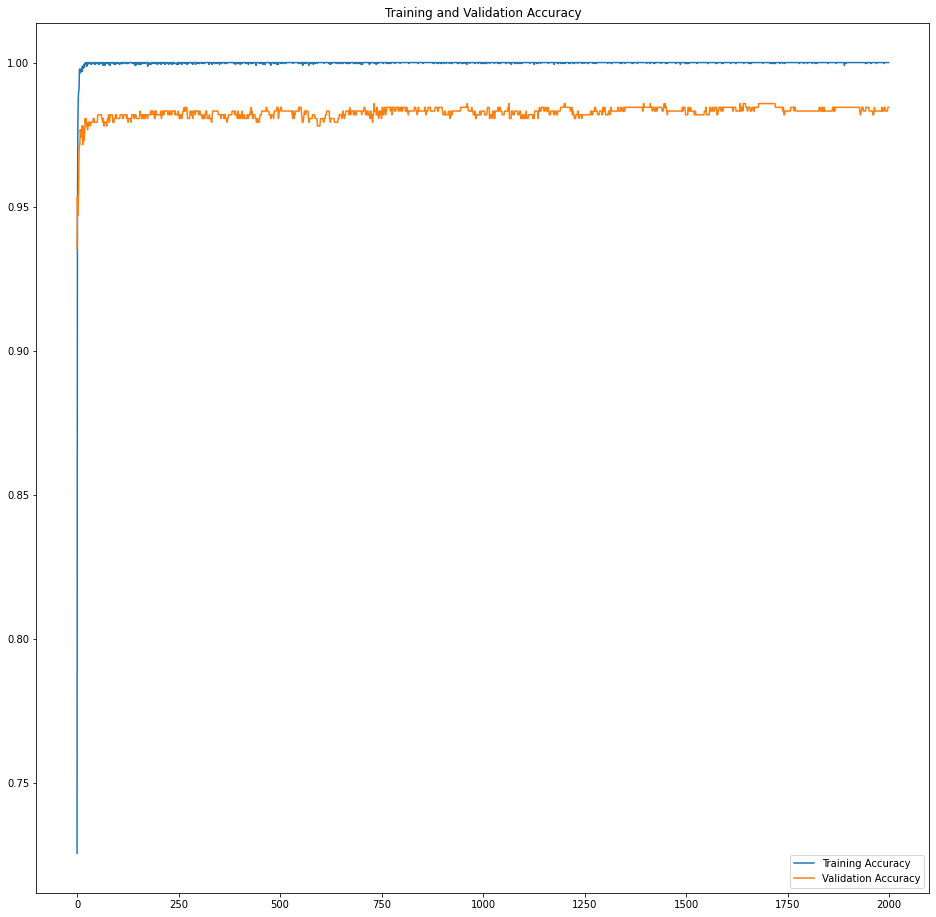

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


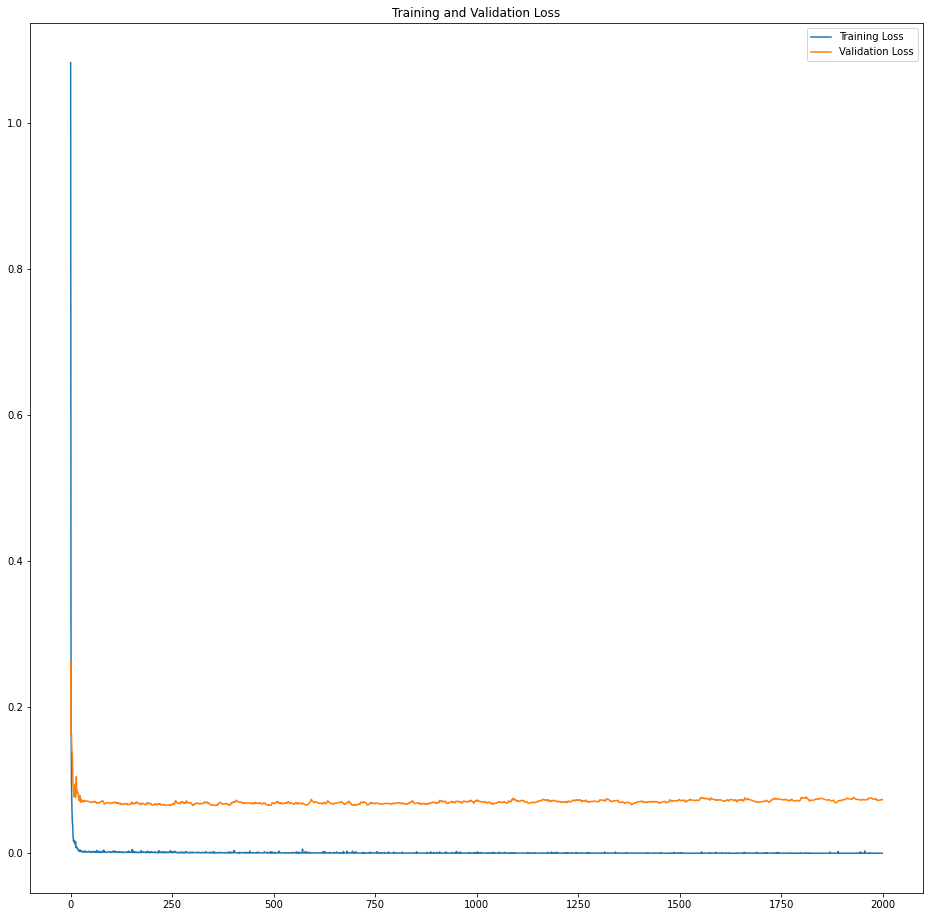

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 341ms/step - loss: 0.4590 - accuracy: 0.8835
test_indoor_ds_results:test loss, test acc: [0.4590100646018982, 0.8835005760192871]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 431ms/step - loss: 0.9618 - accuracy: 0.7990
test_outdoor_ds_results:test loss, test acc: [0.9618289470672607, 0.7990446090698242]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 202ms/step - loss: 1.3069 - accuracy: 0.7638
test_belt_ds_results:test loss, test acc: [1.3069087266921997, 0.7638259530067444]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoCl

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 6s 173ms/step - loss: 1.1196 - accuracy: 0.7597
Epoch200 
 test_indoor_acc=0.8829431533813477 
 test_outdoor_acc=0.7942675352096558 
 test_belt_acc=0.7597461342811584


35/35 [==============================] - 6s 171ms/step - loss: 1.1714 - accuracy: 0.7579
Epoch400 
 test_indoor_acc=0.8851727843284607 
 test_outdoor_acc=0.7920382022857666 
 test_belt_acc=0.7579329013824463


35/35 [==============================] - 6s 171ms/step - loss: 1.1909 - accuracy: 0.7579
Epoch600 
 test_indoor_acc=0.886845052242279 
 test_outdoor_acc=0.7974522113800049 
 test_belt_acc=0.7579329013824463


35/35 [==============================] - 6s 173ms/step - loss: 1.1827 - accuracy: 0.7611
Epoch800 
 test_indoor_acc=0.8907469511032104 
 test_outdoor_acc=0.7933120727539062 
 test_belt_acc=0.7611060738563538


35/35 [==============================] - 6s 173ms/step - loss: 1.2221 - accuracy: 0.7625
Epoch1000 
 test_indoor_acc=0.8829431533813477 
 test_outdoor_acc=0.7945860028266907 
 test_belt_acc=0.7624660134315491


35/35 [==============================] - 6s 173ms/step - loss: 1.2197 - accuracy: 0.7629
Epoch1200 
 test_indoor_acc=0.886845052242279 
 test_outdoor_acc=0.7993630766868591 
 test_belt_acc=0.7629193067550659


35/35 [==============================] - 6s 174ms/step - loss: 1.2455 - accuracy: 0.76161s - loss: 1.1768 
Epoch1400 
 test_indoor_acc=0.8862876296043396 
 test_outdoor_acc=0.800000011920929 
 test_belt_acc=0.7615593671798706


35/35 [==============================] - 6s 174ms/step - loss: 1.2585 - accuracy: 0.7638
Epoch1600 
 test_indoor_acc=0.8907469511032104 
 test_outdoor_acc=0.8012738823890686 
 test_belt_acc=0.7638259530067444


35/35 [==============================] - 6s 174ms/step - loss: 1.2622 - accuracy: 0.7652
Epoch1800 
 test_indoor_acc=0.886845052242279 
 test_outdoor_acc=0.79713374376297 
 test_belt_acc=0.7651858329772949


35/35 [==============================] - 6s 174ms/step - loss: 1.3069 - accuracy: 0.7638
Epoch2000 
 test_indoor_acc=0.8835005760192871 
 test_outdoor_acc=0.7990446090698242 
 test_belt_acc=0.7638259530067444


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

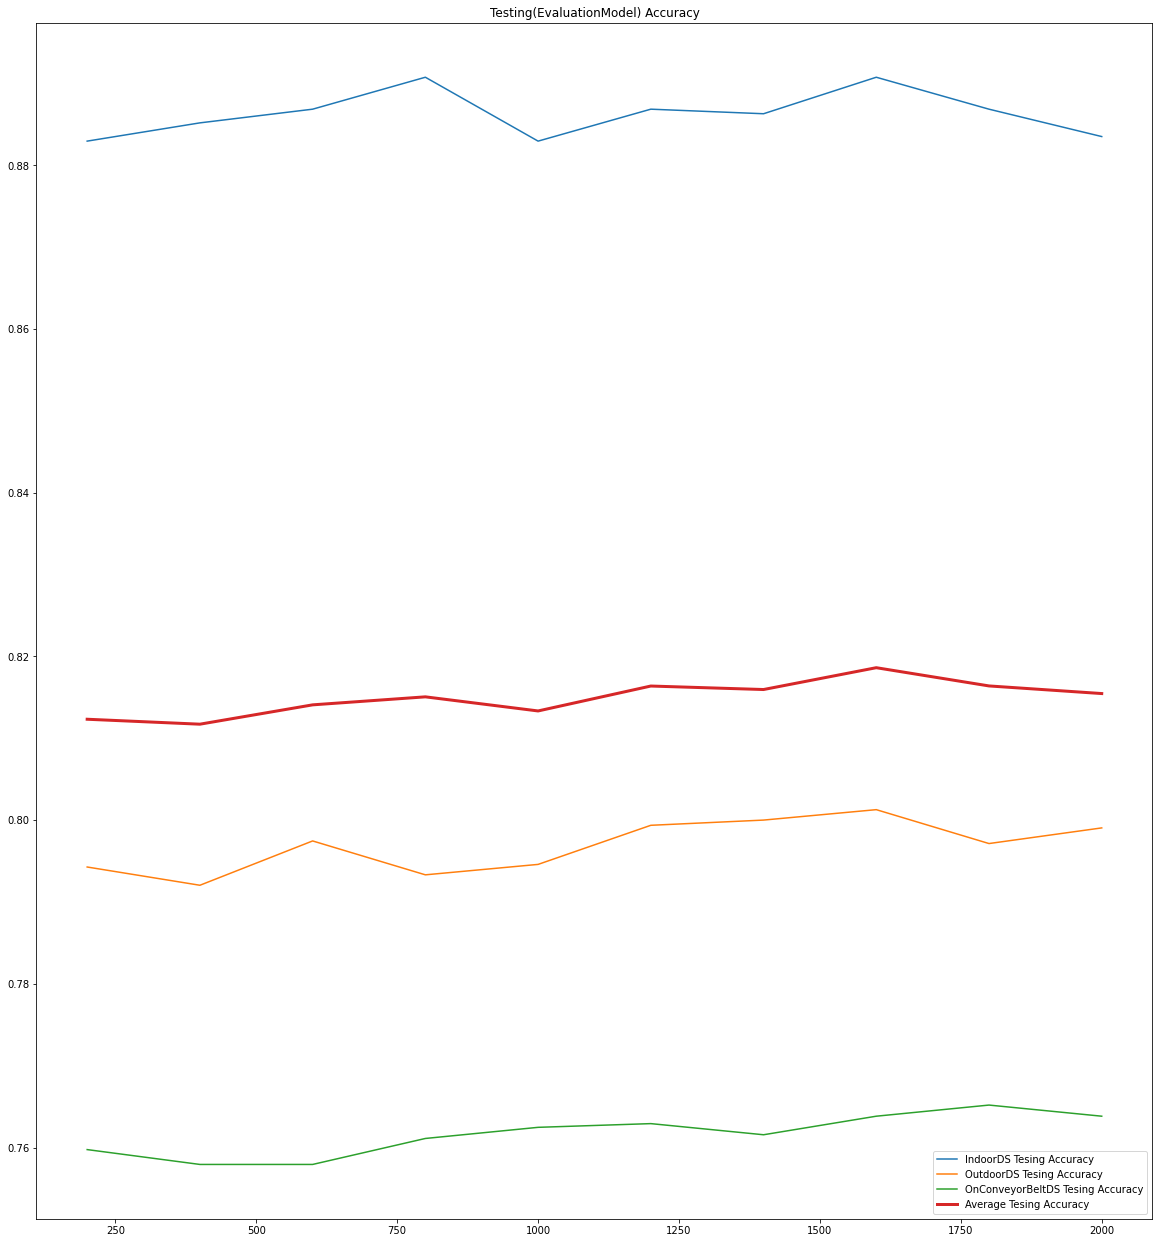

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.8186155954996744
max index -> 7
The [Epoch] of max acc -> 1600


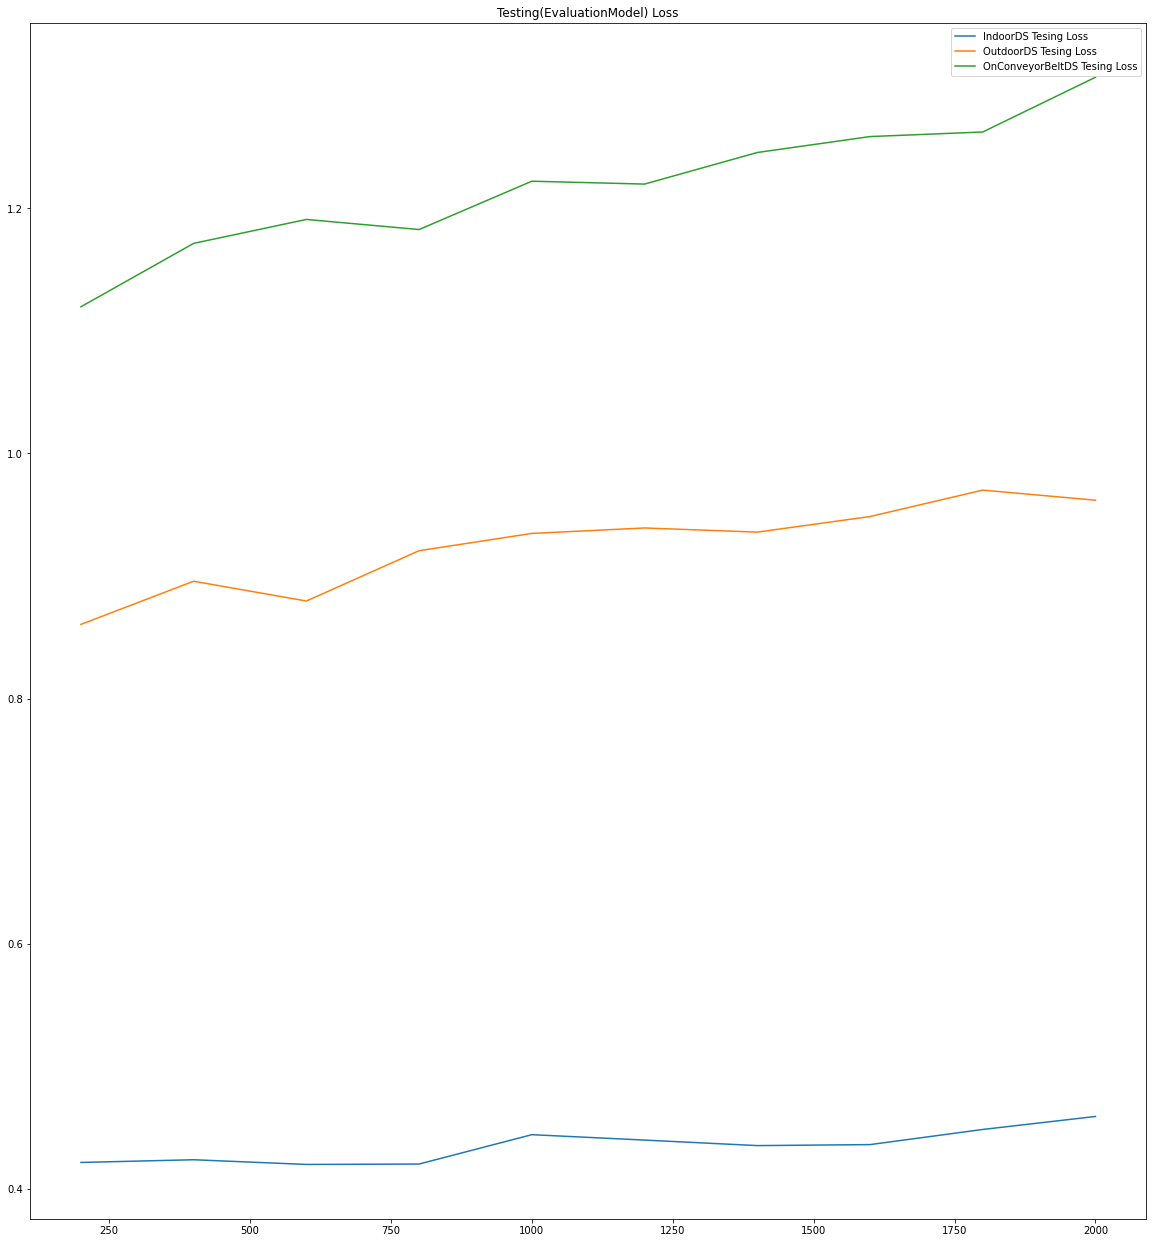

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8829431533813477,
 0.8851727843284607,
 0.886845052242279,
 0.8907469511032104,
 0.8829431533813477,
 0.886845052242279,
 0.8862876296043396,
 0.8907469511032104,
 0.886845052242279,
 0.8835005760192871]

In [38]:
test_outdoor_acc

[0.7942675352096558,
 0.7920382022857666,
 0.7974522113800049,
 0.7933120727539062,
 0.7945860028266907,
 0.7993630766868591,
 0.800000011920929,
 0.8012738823890686,
 0.79713374376297,
 0.7990446090698242]

In [39]:
test_belt_acc

[0.7597461342811584,
 0.7579329013824463,
 0.7579329013824463,
 0.7611060738563538,
 0.7624660134315491,
 0.7629193067550659,
 0.7615593671798706,
 0.7638259530067444,
 0.7651858329772949,
 0.7638259530067444]

In [40]:
test_indoor_loss

[0.4214951694011688,
 0.42369726300239563,
 0.4198642075061798,
 0.42020004987716675,
 0.44414228200912476,
 0.4397401809692383,
 0.4352348744869232,
 0.4360485076904297,
 0.44839948415756226,
 0.4590100646018982]

In [41]:
test_outdoor_loss

[0.8604943156242371,
 0.8957095742225647,
 0.8795545697212219,
 0.9206241369247437,
 0.9347051978111267,
 0.9391591548919678,
 0.9357759356498718,
 0.9484843015670776,
 0.9700547456741333,
 0.9618289470672607]

In [42]:
test_belt_loss

[1.1196303367614746,
 1.171368956565857,
 1.1908763647079468,
 1.1826605796813965,
 1.2220884561538696,
 1.219740629196167,
 1.2455042600631714,
 1.2584959268569946,
 1.262234091758728,
 1.3069087266921997]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.efficientnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=260
img_width=260
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)
del x_test_indoor,x_test_outdoor,x_test_belt
del x_all

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5798
FP=1342
acc=0.8120448179271709
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 81.03448275862068%
2WayConnectorforFoley acc = 97.95918367346938%
2WayFoleyCatheter acc = 88.05970149253731%
3WayConnectorforFoley acc = 98.29059829059828%
3Waystopcock acc = 98.1981981981982%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 48.41269841269841%
BootCover acc = 65.66265060240963%
CottonBall acc = 92.21556886227546%
CottonSwap acc = 74.82517482517483%
Dilator acc = 84.61538461538461%
DisposableInfusionSet acc = 91.1504424778761%
ExtensionTube acc = 50.40650406504065%
FaceShield acc = 73.4567901234568%
FrontLoadSyringe acc = 63.716814159292035%
GauzePad acc = 48.86363636363637%
Glove acc = 71.72619047619048%
GuideWire acc = 53.57142857142857%
LiquidBottle acc = 62.213740458015266%
Mask acc = 98.96103896103897%
NGTube acc = 43.87096774193549%
NasalCannula acc = 62.83185840707964%
Needle acc = 93.57142857142857%
OxygenMask acc = 94.73684210526315%
PPESuit acc = 93.54838709677419%
PharmaceuticalProduct acc = 81.07476635514018%
Pill acc = 96.77871148459

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 94,   0,   0, ...,   0,   0,   0],
       [  0, 144,   0, ...,   0,   0,   0],
       [  0,   0, 118, ...,   0,   0,   1],
       ...,
       [  0,   0,   0, ..., 108,   0,   0],
       [  0,   0,   0, ...,   0, 189,   0],
       [  0,   0,   0, ...,   0,   0,  99]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[81.03448276,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 97.95918367,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 88.05970149, ...,  0.        ,
         0.        ,  0.74626866],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 90.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        88.73239437,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 86.84210526]])

<AxesSubplot:>

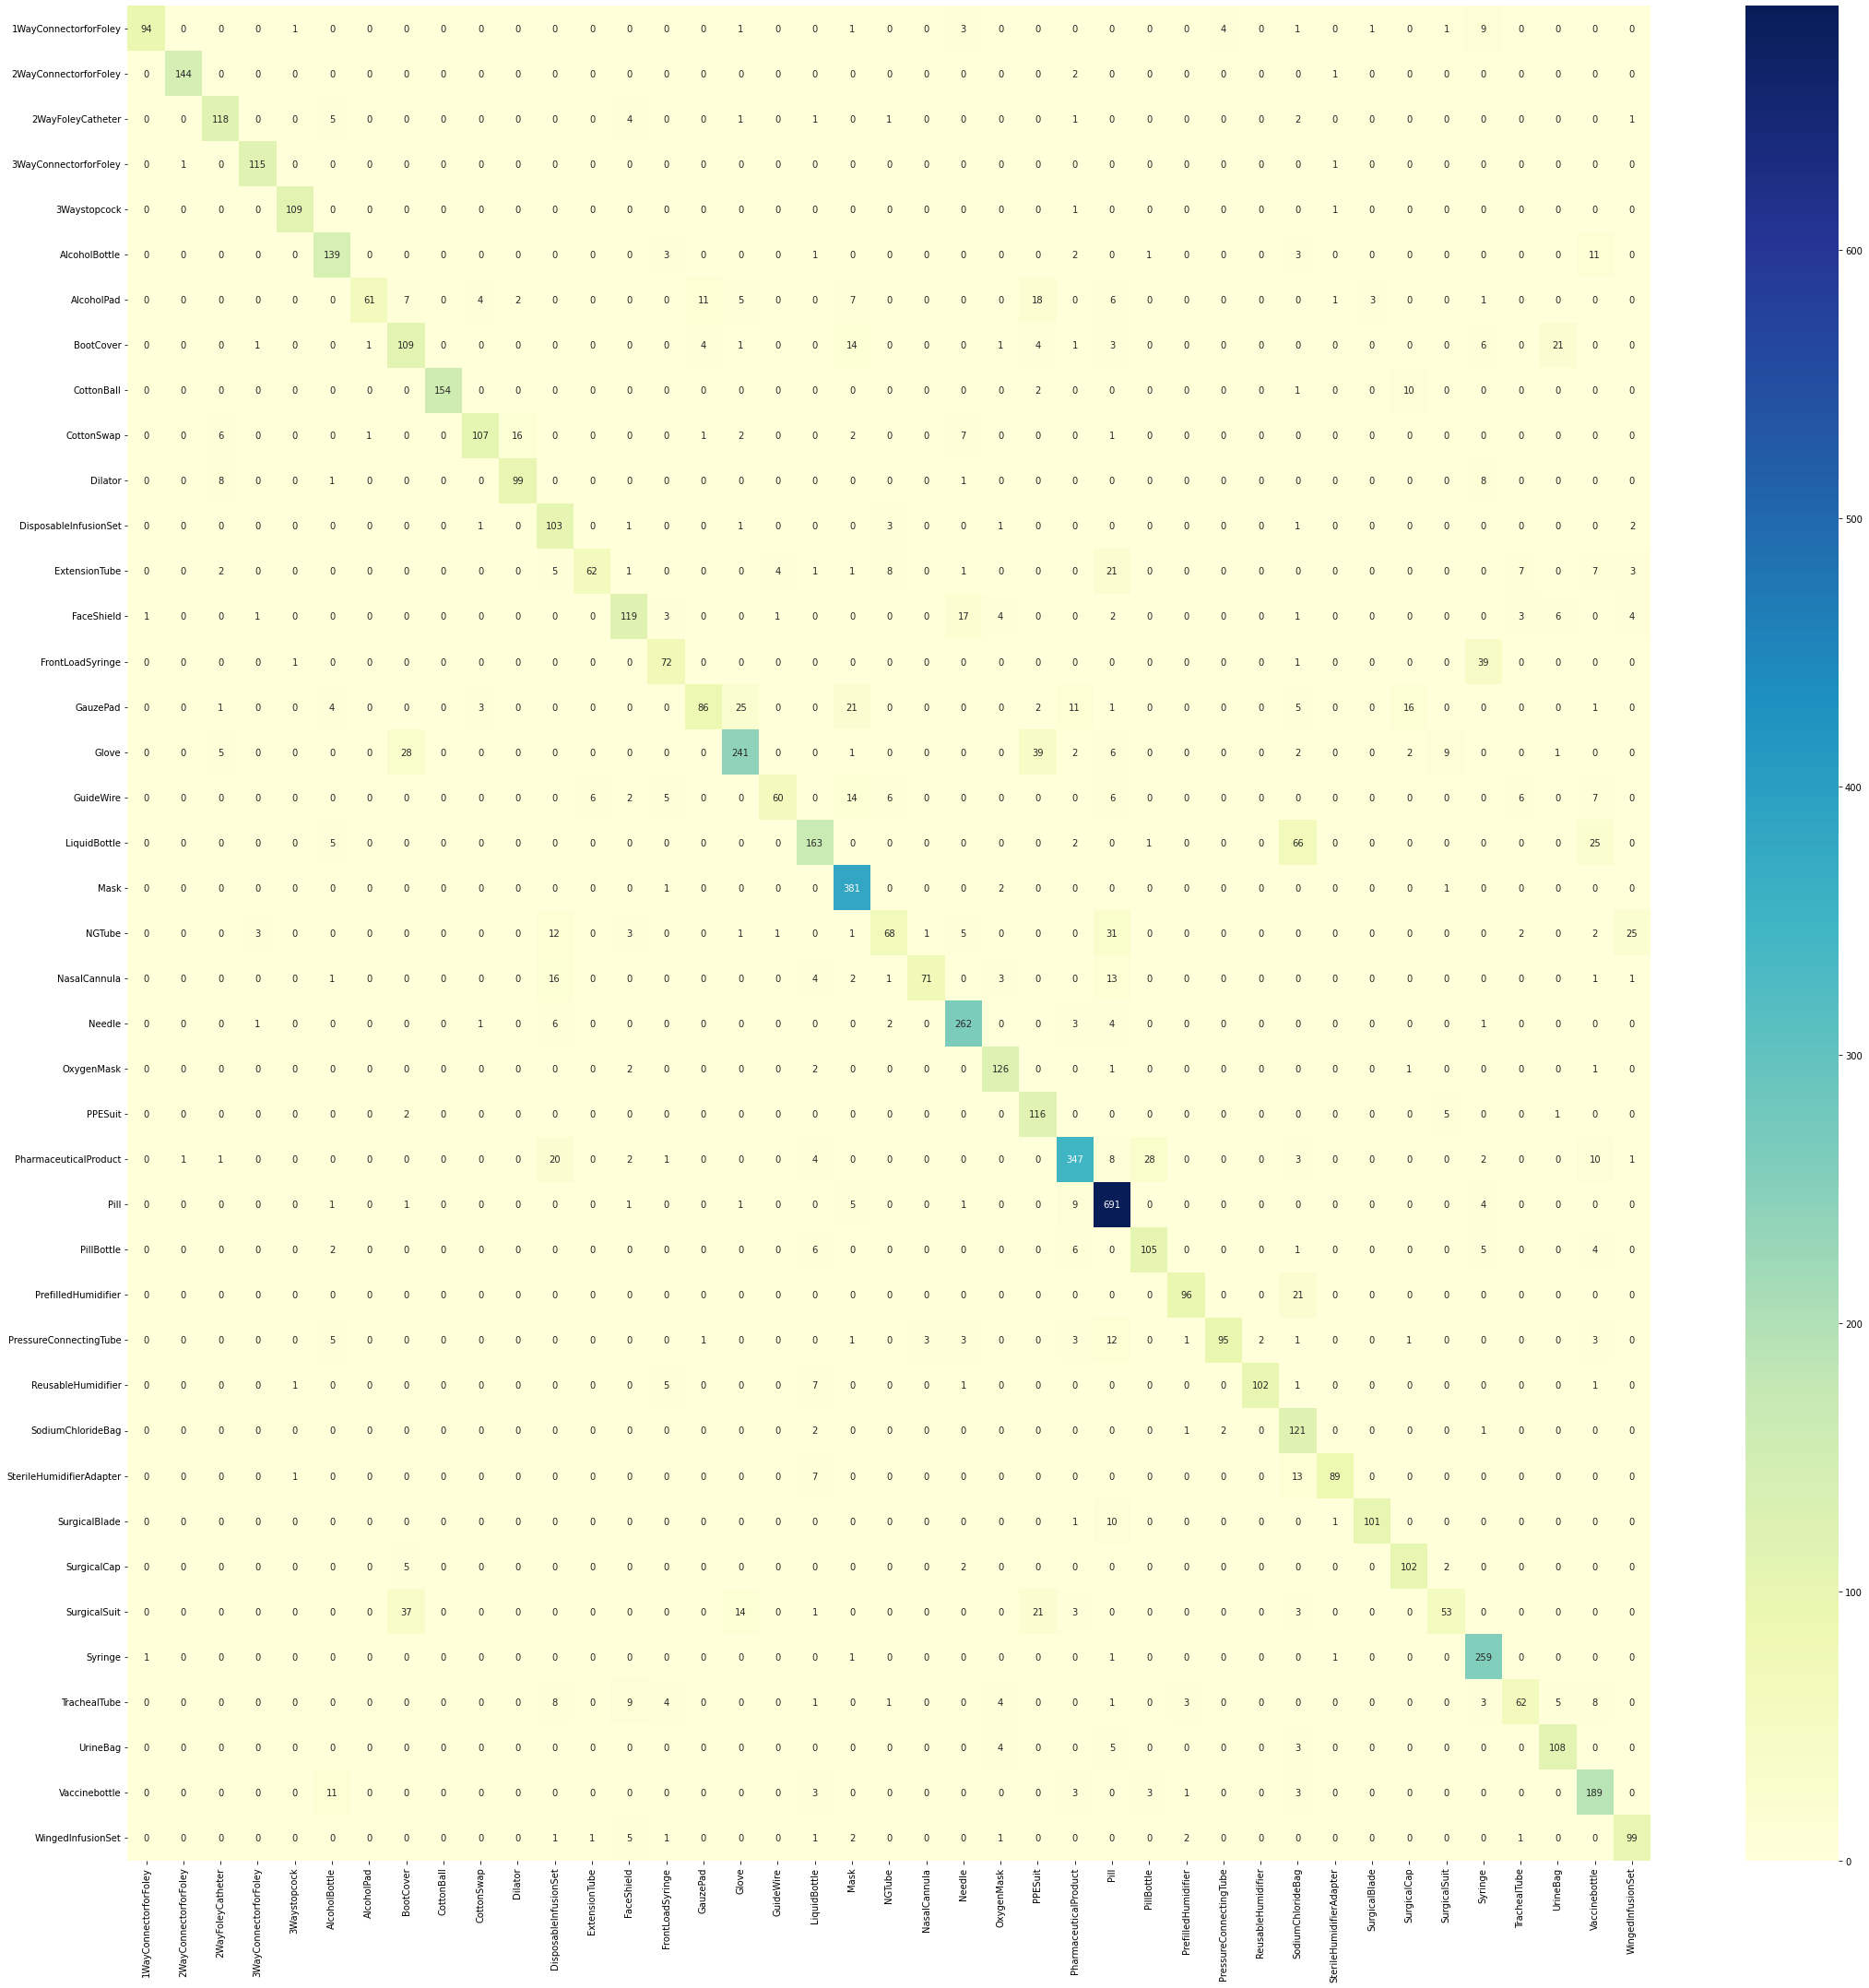

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

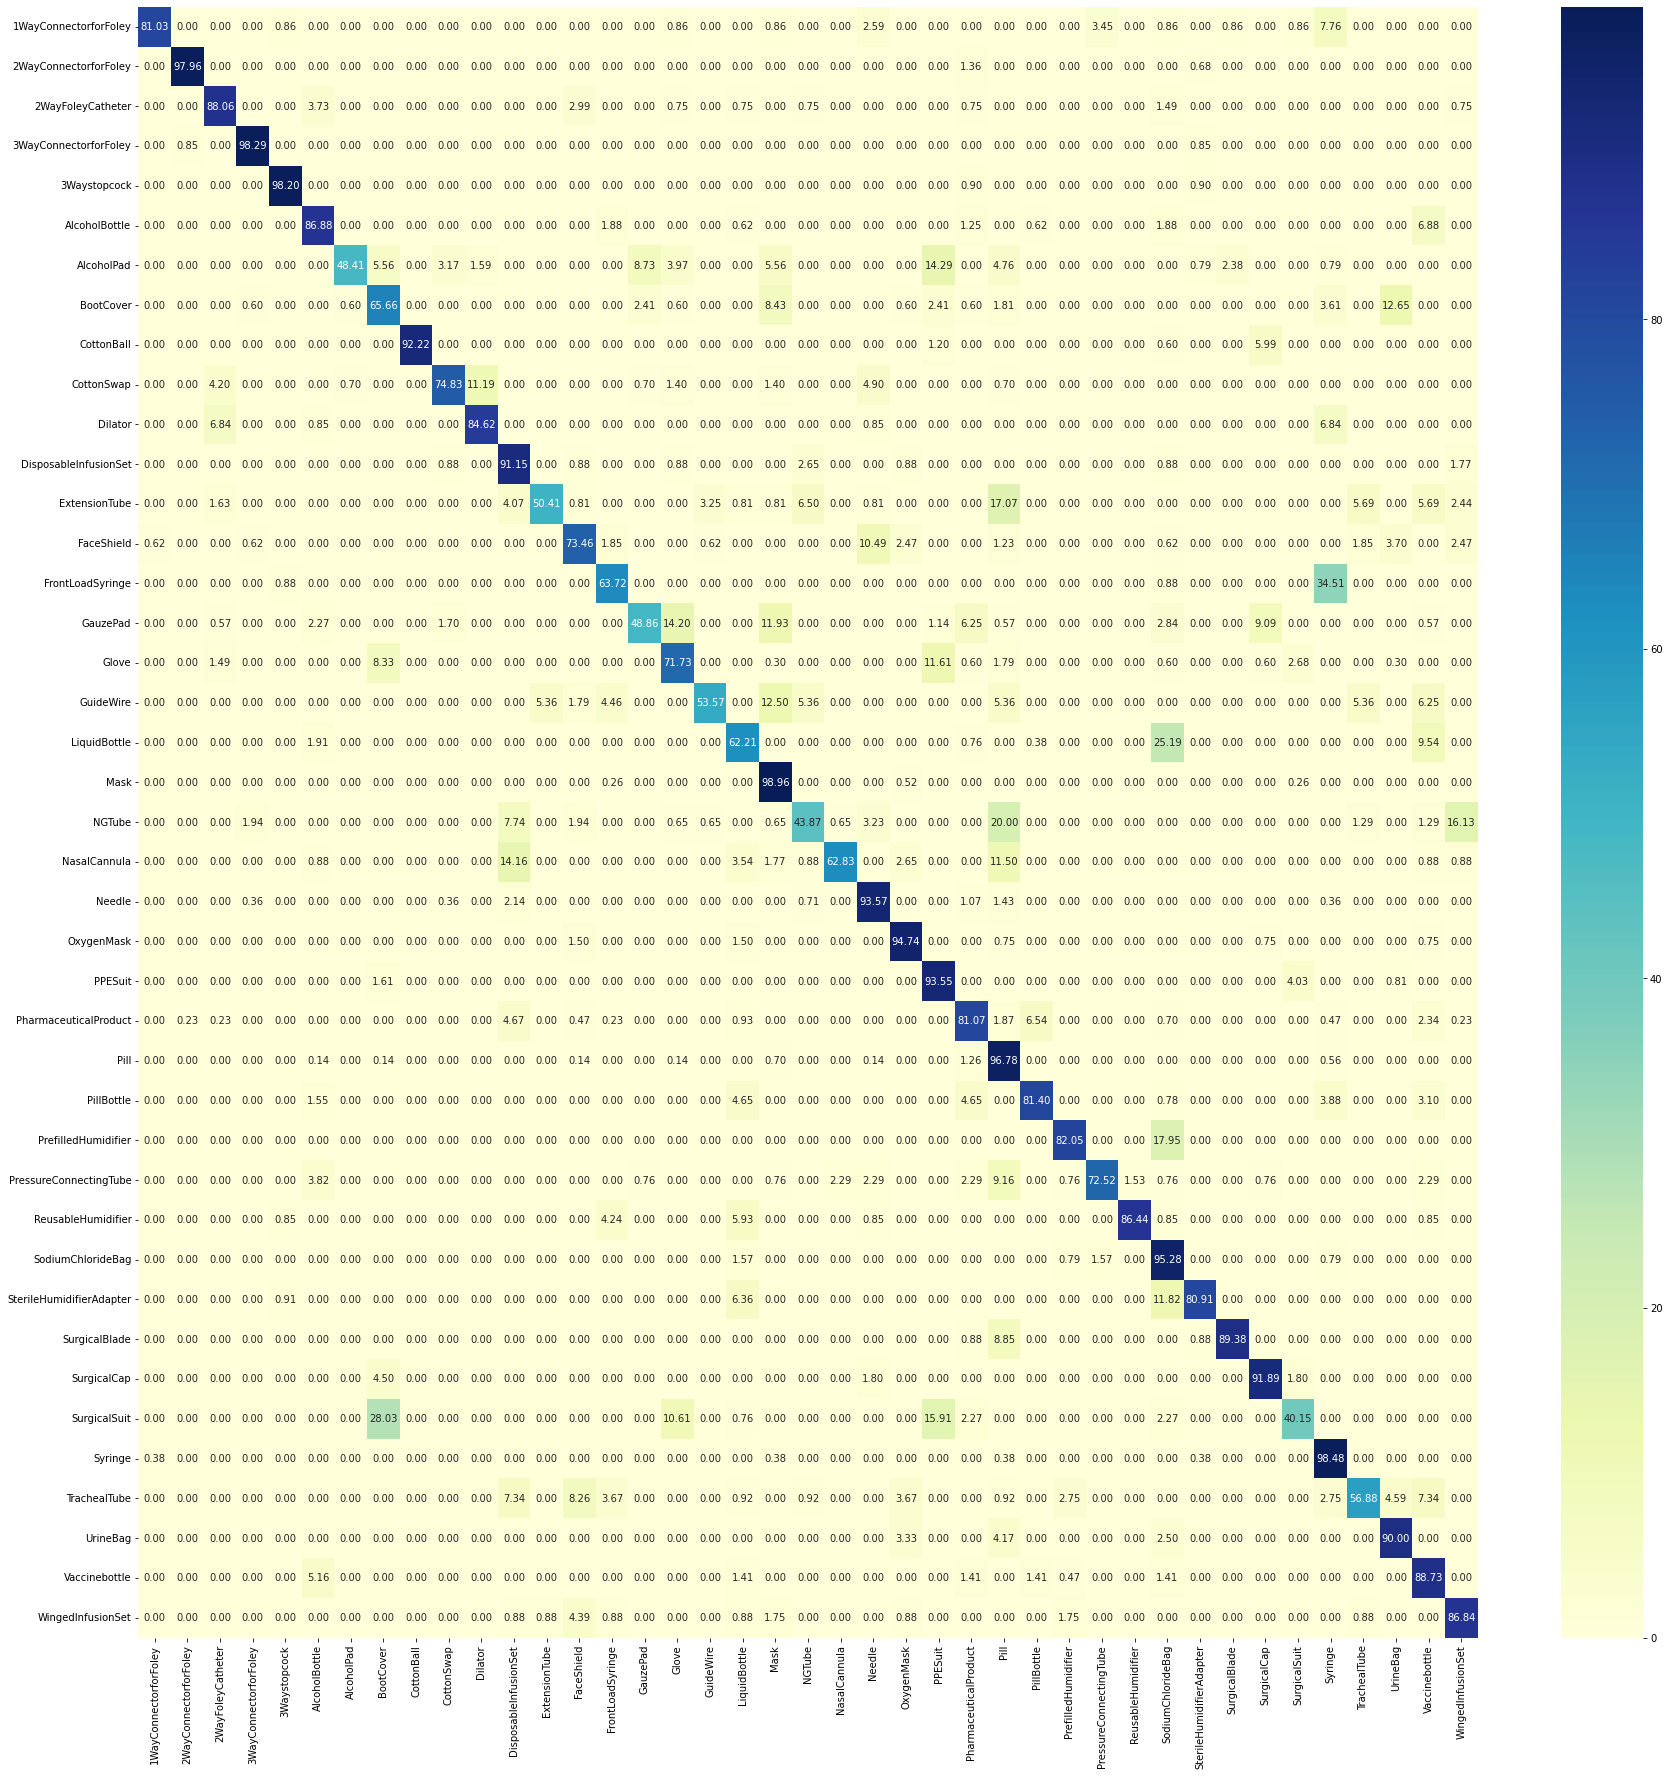

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")